# Quadcopter 6DOF Simulation

A nonlinear 6 degree-of-freedom simulation of a quadcopter.

The following are some of the assumptions made in this simulation:
* Rigid body dynamics
* Products of inertia are all zero due to symmetry of vehicle
* Simplified rotor aerodynamics based on actuator disk theory
  + Assumes rigid propellers
  + 1-D, incompressible flow
  + Uniform airflow over disk representing area of propeller travel
  + No downwash or airflow interference from nearby structure
  + Angle of attack is assumed to be within linear lift coefficient region
  + Small angle approximation applied for angle of attack
  + Propeller blade angle linearly twists from root to tip
* No delays or motor dynamics are included, motor commands achieve desired RPM instantaneously

### Simulation Settings

This first cell will hold the user defined parameters:  
* Configuration and weights of the quadcopter
* Simulation time settings
* Initial conditions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


# Physical Constants
m = 0.1         #kg
Ixx = 0.00062   #kg-m^2
Iyy = 0.00113   #kg-m^2
Izz = 0.9*(Ixx + Iyy) #kg-m^2 (Assume nearly flat object, z=0)
dx = 0.114      #m
dy = 0.0825     #m
g = 9.81  #m/s/s
DTR = 1/57.3; RTD = 57.3


# Simulation time and model parameters
tstep = 0.02            # Sampling time (sec)
simulation_time = 30   # Length of time to run simulation (sec)
t = np.arange(0,simulation_time,tstep)   # time array

# Model size
n_states = 12  # Number of states
n_inputs = 4   # Number of inputs


# Initialize State Conditions
x = np.zeros((n_states,np.size(t)))  # time history of state vectors
# Initial height
x[11,0] = 0.0


# Initialize inputs
u = np.zeros((n_inputs,np.size(t)))  # time history of input vectors
# Initial control inputs
u[:,0] = np.zeros(4)


## Aerodynamics Model

### Propeller Thrust

Using actuator disk theory, which assumes airflow is constant throughout the disk representing the travel of the propeller blades.


**Calculate induced velocity ($v_i$) and thrust (T) by solving the system of 3 equations:**  

Local airstream velocity at center of propeller  
$V' = \sqrt{ U^2 + V^2 + (W - v_i)^2}$  

Total thrust of propeller using local angle of attack where propeller twist is assumed to be linear from root to tip, and averaged over one revolution:  
$T = \frac{1}{4}\rho abcR [(W - v_i) \Omega R + \frac{2}{3}(\Omega R)^2(\theta_0+\frac{3}{4}\theta_1) + (U^2+V^2)(\theta_0 + \frac{1}{2}\theta_1) ]$ 

Thrust equals the change in velocity times the mass flow rate   
$T = \eta 2v_i\rho A V'$

**where:**  

[U,V,W] = Longitudinal, lateral, and vertical components of local airstream velocity  
$v_i$ = induced velocity generated by propeller  
A = area of disk  
$\rho$ = density of air  
a = lift curve slope $(\frac{dC_L}{d\alpha})$  
b = number of propeller blades  
c = mean chord length of propeller blades  
R = propeller blade length (radius of disk)  
$\Omega$ = Angular rate of propeller rotation  
$\theta_0$ = propeller pitch angle at root  
$\theta_1$ = delta pitch twist at propeller tip (assumes linear twist along blade)  
$\eta$ = effeciency of propeller (value of 0-1)

### Propeller Normal Force

Propellers will also produce a normal force, perpendicular to the thrust force. This is not currently modeled.

### Gyroscopic Force

The yawing moment from the propellers will come from the gyroscopic force of the rotating motors and propellers. This is not currently modeled.  
  
---
***Reference:*** *Stevens, B., Lewis, F., and Johnson, E., Aircraft Control and Simulation: Dynamics, Controls Design, and Autonomous Systems. 3rd ed., John Wiley & Sons, 2016.*  
  (Note: topic not covered in previous editions)

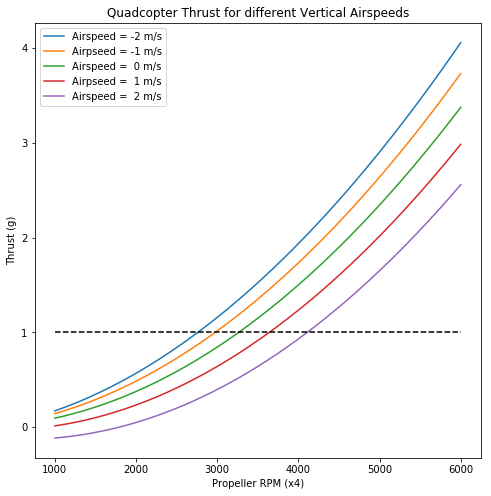

In [2]:
from scipy.optimize import fsolve

# Propeller Thrust equations as a function of propeller induced velocity, vi
def thrustEqn(vi, *prop_params):
    
    # Unpack parameters
    R,A,rho,a,b,c,eta,theta0,theta1,U,V,W,Omega = prop_params
    
    # Calculate local airflow velocity at propeller with vi, V'
    Vprime = np.sqrt(U**2 + V**2 + (W - vi)**2)
    
    # Calculate Thrust averaged over one revolution of propeller using vi
    Thrust = 1/4 * rho * a * b * c * R * \
        ( (W - vi) * Omega * R + 2/3 * (Omega * R)**2 * (theta0 + 3/4 * theta1) + \
          (U**2 + V**2) * (theta0 + 1/2 * theta1) )
    
    # Calculate residual for equation: Thrust = mass flow rate * delta Velocity
    residual = eta * 2 * vi * rho * A * Vprime - Thrust
    
    return residual

    
def Fthrust(x, u, dx, dy):
    # Inputs: Current state x[k], Commanded Propeller RPM inputs u[k],
    #         Propeller location distances dx, dy (m)
    # Returns: Thrust vector for 4 propellers (Newtons)
    
    # Propeller Configuration parameters
    
    R = 0.0762   # propeller length/ disk radius (m) 
    A = np.pi * R ** 2
    rho = 1.225  #kg/m^3  at MSL
    a = 5.7      # Lift curve slope used in example in Stevens & Lewis
    b = 2        # number of blades
    c = 0.0274   # mean chord length (m)
    eta = 1      # propeller efficiency
    
    # Manufacturer propeller length x pitch specification:
    p_diameter = 6  #inches
    p_pitch = 3   #inches
    
    theta0 = 2*np.arctan2(p_pitch, (2 * np.pi * 3/4 * p_diameter/2))
    theta1 = -4 / 3 * np.arctan2(p_pitch, 2 * np.pi * 3/4 * p_diameter/2)
    
    
    # Local velocity at propeller from vehicle state information
    ub, vb, wb = x[0], x[1], x[2]
    p, q, r = x[3], x[4], x[5]
    # Transofrm velocity to local propeller location:
    #     [U,V,W] = [ub,vb,wb] + [p,q,r] x [dx,dy,0]
    U = ub - r * dy
    V = vb + r * dx
    W = wb - q * dx + p * dy
    
    # Convert commanded RPM to rad/s
    Omega = 2 * np.pi / 60 * u
    
    #Collect propeller config, state, and input parameters
    prop_params = (R,A,rho,a,b,c,eta,theta0,theta1,U,V,W,Omega)
    
    # Numerically solve for propeller induced velocity, vi
    # using nonlinear root finder, fsolve, and prop_params
    vi0 = 0.1    # initial guess for vi
    vi = fsolve(thrustEqn, vi0, args=prop_params)
    
    # Plug vi back into Thrust equation to solve for T
    Vprime = np.sqrt(U**2 + V**2 + (W - vi)**2)
    Thrust = eta * 2 * vi * rho * A * Vprime
    
    return Thrust

    
# Torque function
def T(F,dx,dy):
    # Returns torque about cg given thrust force and dx,dy distance from cg
    
    #### PLACEHOLDER ####
    return 0


# Plot Thrust as a function of RPM for various vertical velocity conditions
RPM = np.linspace(1000,6000,200)
vertvel = np.array([0,0,1] + 9*[0])
Thrust_m2vel = np.array([Fthrust(2*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
Thrust_m1vel = np.array([Fthrust(1*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
Thrust_0vel  = np.array([Fthrust(0*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
Thrust_p1vel = np.array([Fthrust(-1*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
Thrust_p2vel = np.array([Fthrust(-2*vertvel,rpmIn,dx,dy) for rpmIn in RPM])
fig = plt.figure(figsize=(8,8))
plt.plot(RPM, 4 * Thrust_m2vel / (m*g) )
plt.plot(RPM, 4 * Thrust_m1vel / (m*g) )
plt.plot(RPM, 4 * Thrust_0vel / (m*g) )
plt.plot(RPM, 4 * Thrust_p1vel / (m*g) )
plt.plot(RPM, 4 * Thrust_p2vel / (m*g) )
plt.plot(RPM, np.ones(np.size(RPM)), 'k--')
plt.legend(('Airspeed = -2 m/s','Airpseed = -1 m/s','Airspeed =  0 m/s', \
            'Airpseed =  1 m/s','Airspeed =  2 m/s'), loc='upper left')
plt.xlabel('Propeller RPM (x4)')
plt.ylabel('Thrust (g)')
plt.title('Quadcopter Thrust for different Vertical Airspeeds')
plt.show()


## Equations of Motion

**Calculate the derivative of the state as a function of the current state and control inputs**

$\dot{u} = -g\sin(\theta) + rv - qw$  

$\dot{v} = g\sin(\phi)\cos(\theta) -ru + pw$  

$\dot{w} = \frac{1}{m}(-F_{z}) + g\cos(\phi)\cos(\theta) + qu - pv$  

$\dot{p} = \frac{1}{I_{xx}}(L + (I_{yy}-I_{zz})qr)$  

$\dot{q} = \frac{1}{I_{yy}}(M + (I_{zz}-I_{xx})pr)$  

$\dot{r} = \frac{1}{I_{zz}}(N + (I_{xx}-I_{yy})pq)$  

$\dot{\phi} = p + (q \sin\phi + r \cos\phi) \tan\theta$  

$\dot{\theta} = q \cos\phi - r \sin\phi$  

$\dot{\psi} = (q \sin\phi + r \cos\phi) \sec\theta$  

$\dot{x}^{E} = c_{\theta}c_{\psi}u^{b} + (-c_{\phi}s_{\psi}+s_{\phi}s_{\theta}c_{\psi})v^{b} + (s_{\phi}s_{\psi}+c_{\phi}s_{\theta}c_{\psi})w^{b}$  

$\dot{y}^{E} = c_{\theta}s_{\psi}u^{b} + (c_{\phi}c_{\psi}+s_{\phi}s_{\theta}s_{\psi})v^{b} + (-s_{\phi}c_{\psi}+c_{\phi}s_{\theta}s_{\psi})w^{b}$  

$\dot{h}^{E} = -s_{\theta}u^{b} + s_{\phi}c_{\theta}v^{b} + c_{\phi}c_{\theta}w^{b}$  

**where**

$F_{z} = F_1 + F_2 + F_3 + F_4$  

$L = F_1 d_{1y} - F_2 d_{2y} - F_3 d_{3y} + F_4 d_{4y}$  

$M = -F_1 d_{1x} + F_2 d_{2x} - F_3 d_{3x} + F_4 d_{4x}$  

$N = -T(F_1,d_{1x},d_{1y}) - T(F_2,d_{2x},d_{2y}) + T(F_3,d_{3x},d_{3y}) + T(F_4,d_{4x},d_{4y})$  


and $h^E$ is positive in the up direction.

In [3]:
# Nonlinear Dynamics Equations of Motion
def stateDerivative(x,u):
    # Inputs: state vector (x), input vector (u)
    # Returns: time derivative of state vector (xdot)
    
    #  State Vector Reference:
    #idx  0, 1, 2, 3, 4, 5,  6,   7,   8,   9, 10, 11
    #x = [u, v, w, p, q, r, phi, the, psi, xE, yE, hE]
    
    # Store state variables in a readable format
    ub = x[0]
    vb = x[1]
    wb = x[2]
    p = x[3]
    q = x[4]
    r = x[5]
    phi = x[6]
    theta = x[7]
    psi = x[8]
    xE = x[9]
    yE = x[10]
    hE = x[11]
    
    # Calculate forces from propeller inputs (u)
    F1 = Fthrust(x, u[0],  dx,  dy)
    F2 = Fthrust(x, u[1], -dx, -dy)
    F3 = Fthrust(x, u[2],  dx, -dy)
    F4 = Fthrust(x, u[3], -dx,  dy)
    Fz = F1 + F2 + F3 + F4
    L = (F2 + F3) * dy - (F1 + F4) * dy
    M = (F1 + F3) * dx - (F2 + F4) * dx
    N = -T(F1,dx,dy) - T(F2,dx,dy) + T(F3,dx,dy) + T(F4,dx,dy)
    
    # Pre-calculate trig values
    cphi = np.cos(phi);   sphi = np.sin(phi)
    cthe = np.cos(theta); sthe = np.sin(theta)
    cpsi = np.cos(psi);   spsi = np.sin(psi)
    
    # Calculate the derivative of the state matrix using EOM
    xdot = np.zeros(12)
    
    xdot[0] = -g * sthe + r * vb - q * wb  # = udot
    xdot[1] = g * sphi*cthe - r * ub + p * wb # = vdot
    xdot[2] = 1/m * (-Fz) + g*cphi*cthe + q * ub - p * vb # = wdot
    xdot[3] = 1/Ixx * (L + (Iyy - Izz) * q * r)  # = pdot
    xdot[4] = 1/Iyy * (M + (Izz - Ixx) * p * r)  # = qdot
    xdot[5] = 1/Izz * (N + (Ixx - Iyy) * p * q)  # = rdot
    xdot[6] = p + (q*sphi + r*cphi) * sthe / cthe  # = phidot
    xdot[7] = q * cphi - r * sphi  # = thetadot
    xdot[8] = (q * sphi + r * cphi) / cthe  # = psidot
    
    xdot[9] = cthe*cpsi*ub + (-cphi*spsi + sphi*sthe*cpsi) * vb + \
        (sphi*spsi+cphi*sthe*cpsi) * wb  # = xEdot
        
    xdot[10] = cthe*spsi * ub + (cphi*cpsi+sphi*sthe*spsi) * vb + \
        (-sphi*cpsi+cphi*sthe*spsi) * wb # = yEdot
        
    xdot[11] = -1*(-sthe * ub + sphi*cthe * vb + cphi*cthe * wb) # = hEdot
    
    return xdot




## Control Law

This is a placeholder for where the control law will determine the input commands it sends to the propeller motors.

For now, we can try hard coding in some example open loop control inputs at different times to see how the model dynamics respond.

In [4]:
def controlInputs(x, t):
    # Inputs: Current state x[k], time t
    # Returns: Control inputs u[k]
    
    #### Placeholder Function ####
    
    # Trim RPM for all 4 propellers to provide thrust for a level hover
    trim = 3200
    
    pitch_cmd = 0
    roll_cmd = 0
    climb_cmd = 0
    yaw_cmd = 0
    
    # Example open loop control inputs to test dynamics:
    #  Climb
    if t < 11.0:
        climb_cmd = 500
    
    #  Pitch Forward
    if t > 8.0:
        pitch_cmd = -10
    if t > 9.0:
        pitch_cmd = 10
    if t > 10.0:
        pitch_cmd = 0
    
    #  Pitch Backward
    if t > 12.0:
        pitch_cmd = 15
    if t > 13.0:
        pitch_cmd = -15
    if t > 14.0:
        pitch_cmd = 0
    
    #  Increase lift
    if t > 16.0:
        climb_cmd = 150
        
    
    # RPM command based on pitch, roll, climb, yaw commands
    u = np.zeros(4)
    u[0] = trim + ( pitch_cmd + roll_cmd + climb_cmd - yaw_cmd) / 4
    u[1] = trim + (-pitch_cmd - roll_cmd + climb_cmd - yaw_cmd) / 4
    u[2] = trim + ( pitch_cmd - roll_cmd + climb_cmd + yaw_cmd) / 4
    u[3] = trim + (-pitch_cmd + roll_cmd + climb_cmd + yaw_cmd) / 4
    
    
    return u

## Numerical Integration

In [5]:
# 4th Order Runge Kutta Calculation
def RK4(x,u,dt):
    # Inputs: x[k], u[k], dt (time step, seconds)
    # Returns: x[k+1]
    
    # Calculate slope estimates
    K1 = stateDerivative(x, u)
    K2 = stateDerivative(x + K1 * dt / 2, u)
    K3 = stateDerivative(x + K2 * dt / 2, u)
    K4 = stateDerivative(x + K3 * dt, u)
    
    # Calculate x[k+1] estimate using combination of slope estimates
    x_next = x + 1/6 * (K1 + 2*K2 + 2*K3 + K4) * dt
    
    return x_next



# March through time array and numerically solve for vehicle states

for k in range(0, np.size(t) - 1): 
        
    # Determine control inputs based on current state
    u[:,k] = controlInputs(x[:,k], t[k])
    
    # Predict state after one time step
    x[:,k+1] = RK4(x[:,k], u[:,k], tstep)
       


## Plot Results

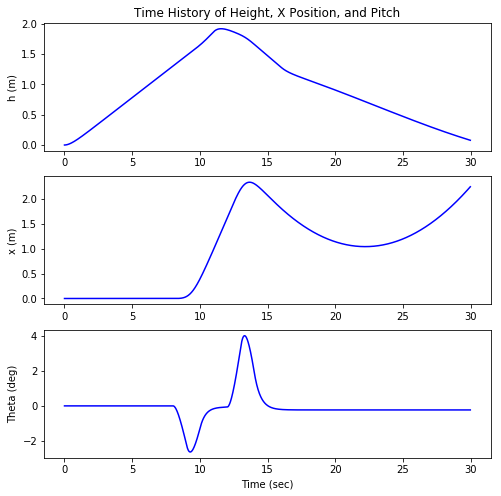

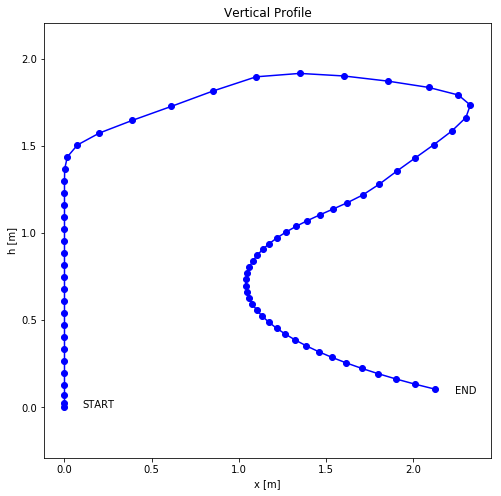

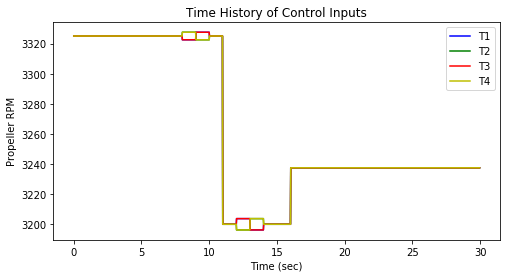

In [6]:


plt.figure(1, figsize=(8,8))
plt.subplot(311)
plt.plot(t,x[11,:],'b',label='h')
plt.ylabel('h (m)')
#plt.xlabel('Time (sec)')
#plt.legend(loc='best')
plt.title('Time History of Height, X Position, and Pitch')

plt.subplot(312)
plt.plot(t,x[9,:],'b',label='x')
plt.ylabel('x (m)')
#plt.xlabel('Time (sec)')

plt.subplot(313)
plt.plot(t,x[7,:]*RTD,'b',label='theta')
plt.ylabel('Theta (deg)')
plt.xlabel('Time (sec)')

plt.figure(2, figsize=(8,8))
ax = plt.subplot(1,1,1)
plt.plot(x[9,0:-1:20],x[11,0:-1:20],'bo-',label='y')
plt.text(x[9,0] + 0.1, x[11,0],'START')
plt.text(x[9,-1], x[11,-1],'END')
plt.ylabel('h [m]'); plt.xlabel('x [m]')
ax.axis('equal')
#plt.legend(loc='best')
plt.title('Vertical Profile')

plt.figure(3, figsize=(8,4))
plt.plot(t[0:-1],u[0,0:-1],'b',label='T1')
plt.plot(t[0:-1],u[1,0:-1],'g',label='T2')
plt.plot(t[0:-1],u[2,0:-1],'r',label='T3')
plt.plot(t[0:-1],u[3,0:-1],'y',label='T4')
plt.xlabel('Time (sec)')
plt.ylabel('Propeller RPM')
plt.legend(loc='best')
plt.title('Time History of Control Inputs')

plt.show()

In [8]:
#Store time, input, and state data to a json file for visualization
import json, codecs
log_filename = "visualizer/sim_log.json"
with open(log_filename, "w") as logfile:
    logfile.write("var sim_data = ")
json.dump([t.tolist(), u.tolist(),x.tolist()], \
          codecs.open(log_filename, 'a', encoding='utf-8'), \
          separators=(',', ':'), indent=4)